In [8]:
import pandas as pd
import numpy as np
import DecisionTree as dt
import RandomForest as rf

#### Data processing

In [9]:
# Read the features CSV file
df = pd.read_csv(r"E:\Uni\Kuenstliche-Intelligenz\Projektarbeit\Projektarbeit-Kuenstliche-Intelligenz\data\features.csv", sep=';', header=None)

# Shave off unnecessary data
df = df.iloc[1:, 3:]

# Put classification column at the end
df = df.reindex(columns=[4, 5, 6, 7, 3])

# Convert all entries to numbers
df = df.apply(pd.to_numeric, errors='coerce')

# Remove the multitool classification
#df = df[df.iloc[:, -1] < 3]

# Shuffle dataset
df = df.sample(frac=1)

#### Split train / test data

In [10]:
train = df.to_numpy(dtype='float32')[int(len(df)*0.8):]
test = df.to_numpy(dtype='float32')[:int(len(df)*0.8)]

#### Build decision tree

In [11]:
tree = dt.build_tree(train, 8, 1)

#### Test decision tree accuracy with test dataset

In [12]:
runs = 0
correct = 0
for row in test:
    runs += 1
    pred = dt.predict(tree, row)
    expected = row[-1]

    if expected == pred:
        correct +=1

print(correct/runs)

0.47855917667238423


#### Test accuracy with a bunch of trees

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

In [14]:
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
print('Accuracy Decision Tree: ', tree_clf.score(X_test, y_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

[Text(0.3728448275862069, 0.9722222222222222, 'X[0] <= 0.284\ngini = 0.494\nsamples = 146\nvalue = [81, 65]'),
 Text(0.1206896551724138, 0.9166666666666666, 'X[3] <= 0.048\ngini = 0.188\nsamples = 19\nvalue = [17, 2]'),
 Text(0.08620689655172414, 0.8611111111111112, 'X[3] <= 0.037\ngini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(0.05172413793103448, 0.8055555555555556, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.1206896551724138, 0.8055555555555556, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.15517241379310345, 0.8611111111111112, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]'),
 Text(0.625, 0.9166666666666666, 'X[0] <= 0.731\ngini = 0.5\nsamples = 127\nvalue = [64, 63]'),
 Text(0.3879310344827586, 0.8611111111111112, 'X[1] <= 9.5\ngini = 0.489\nsamples = 94\nvalue = [40, 54]'),
 Text(0.1896551724137931, 0.8055555555555556, 'X[0] <= 0.386\ngini = 0.465\nsamples = 19\nvalue = [12, 7]'),
 Text(0.15517241379310345, 0.75, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.22

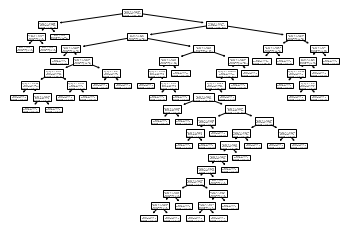

In [ ]:
tree.plot_tree(tree_clf)

In [15]:
max_tree_depth = 20
results = []
for i in range(max_tree_depth):
    tree = dt.build_tree(train, i, 3)
    runs = 0
    correct = 0
    for row in test:
        runs += 1
        pred = dt.predict(tree, row)
        expected = row[-1]

        if expected == pred:
            correct +=1
    results.append(correct/runs)

results

[0.4734133790737564,
 0.4734133790737564,
 0.516295025728988,
 0.5145797598627787,
 0.5060034305317325,
 0.5025728987993139,
 0.48027444253859347,
 0.47684391080617494,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564,
 0.4734133790737564]

#### Random forest accuracy test

In [16]:
max_depths = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
min_sizes = [3 for i in range(len(max_depths))]

forest = rf.build_forest(train, max_depths, min_sizes)

runs = 0
correct = 0
for row in test:
    runs += 1
    pred = rf.predict(forest, row)
    expected = row[-1]

    if expected == pred:
        correct +=1

print(correct/runs)

0.4734133790737564
